<a href="https://colab.research.google.com/github/Jvrco/Training-FashionMNIST/blob/main/Training_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

# Imports e Downloads

In [ ]:
%%capture
!pip install torchsummary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils import data
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F


%matplotlib inline


In [ ]:
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X = fashion_mnist.data
y = fashion_mnist.target

y = y.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# As imagens são carregadas internamente com uma biblioteca de processamento de
# imagens e precisam ser convertidas para um formato apropriado (ToTensor)
transform = transforms.ToTensor()

In [ ]:

train_ds = datasets.FashionMNIST(
    root = ".",
    train = True,
    download = True,
    transform = transform
)

# Criar um conjunto de validação a partir de um subconjunto aleatório
# com 15% dos dados de treino originais
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

test_ds = datasets.FashionMNIST(
    root = ".",
    train = False,
    download = True,
    transform = transform
)

In [ ]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 128

In [ ]:
train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

In [ ]:
instances, targets = next(iter(test_dl))

In [ ]:
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

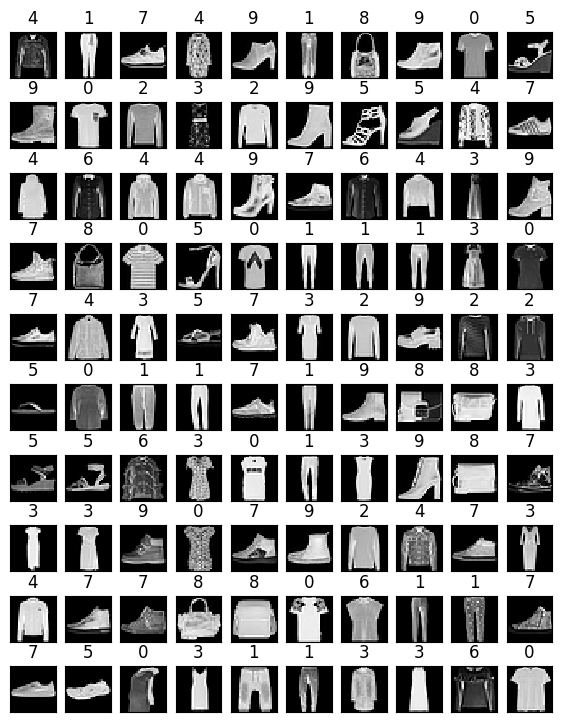

In [ ]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

# Modelo base

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8824285714285715
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1394
           1       0.99      0.96      0.98      1402
           2       0.79      0.82      0.81      1407
           3       0.88      0.92      0.90      1449
           4       0.77      0.84      0.80      1357
           5       0.97      0.96      0.96      1449
           6       0.74      0.59      0.66      1407
           7       0.93      0.94      0.94      1359
           8       0.96      0.98      0.97      1342
           9       0.95      0.96      0.95      1434

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



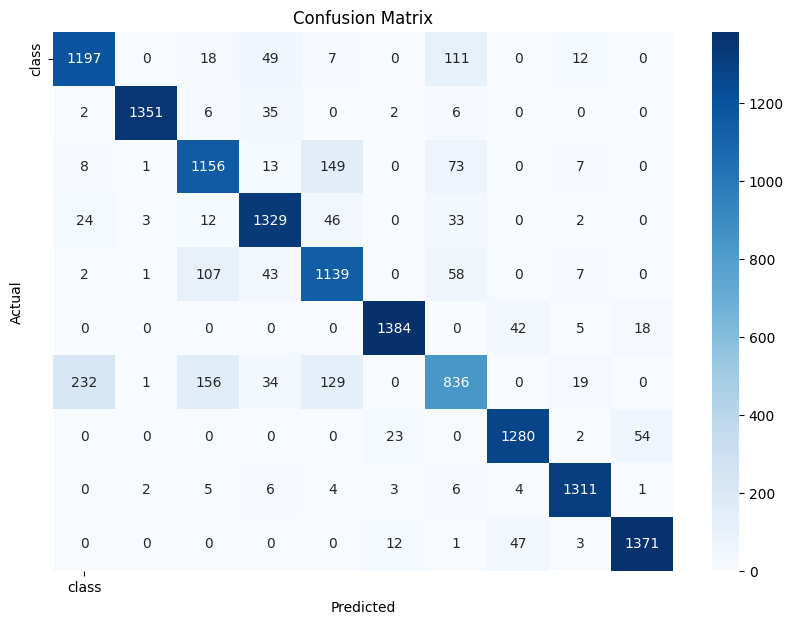

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=fashion_mnist.target_names, yticklabels=fashion_mnist.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# MLP

In [ ]:
class MyFirstModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.flatten = nn.Flatten()

    self.mlp = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )


  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [ ]:
test_model = MyFirstModel(10)
test_model(instances).shape

torch.Size([128, 10])

In [ ]:
test_model = MyFirstModel(10)
test_model(instances).shape

torch.Size([128, 10])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
classifier = MyFirstModel(10).to(device)

In [ ]:
summary(classifier, input_size=(1, 28, 28), batch_size=BATCH_SIZE_TRAIN, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                   [64, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.89
Params size (MB): 1.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
LEARNING_RATE = 1e-4

In [ ]:
optimizer = optim.Adam(params=classifier.parameters(), lr=LEARNING_RATE)

In [ ]:
EPOCHS = 25 # número total de épocas

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    logits = classifier(train_instances)

    optimizer.zero_grad()

    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    loss.backward()

    optimizer.step()
  return train_loss.avg

In [ ]:
def validation_step(model, val_dl, loss_fn, device):
  model.eval()

  val_loss = AverageMeter()
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      logits = classifier(val_instances)

      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(classifier, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(classifier, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/25]
-----------------------------------
Train loss: 0.779997
Valid. loss: 0.542254

Época [2/25]
-----------------------------------
Train loss: 0.498982
Valid. loss: 0.483861

Época [3/25]
-----------------------------------
Train loss: 0.449516
Valid. loss: 0.436834

Época [4/25]
-----------------------------------
Train loss: 0.421339
Valid. loss: 0.414691

Época [5/25]
-----------------------------------
Train loss: 0.401259
Valid. loss: 0.399986

Época [6/25]
-----------------------------------
Train loss: 0.387271
Valid. loss: 0.38526

Época [7/25]
-----------------------------------
Train loss: 0.373519
Valid. loss: 0.374918

Época [8/25]
-----------------------------------
Train loss: 0.362279
Valid. loss: 0.369806

Época [9/25]
-----------------------------------
Train loss: 0.351151
Valid. loss: 0.369275

Época [10/25]
-----------------------------------
Train loss: 0.342858
Valid. loss: 0.356728

Época [11/25]
-----------------------------------
Train loss: 0.33483


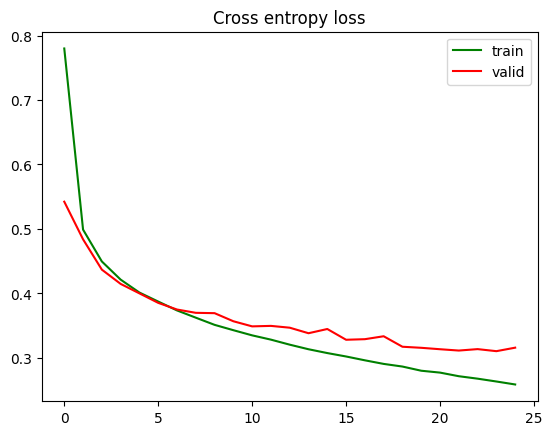

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [ ]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        logits = classifier(test_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))


preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

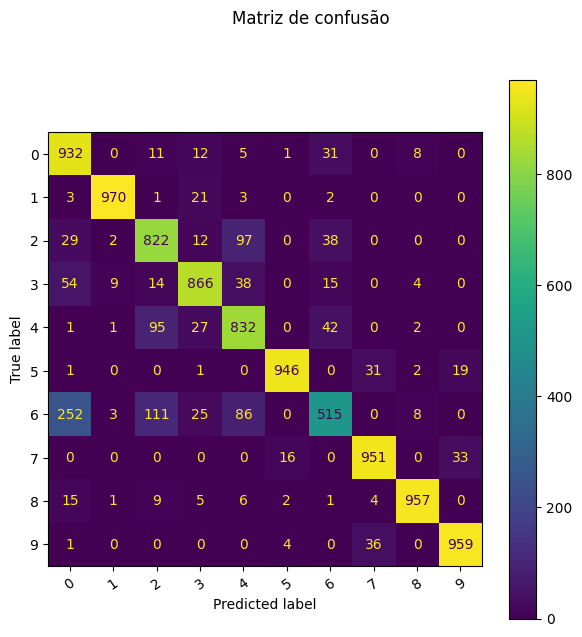

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = list(str(i) for i in range(10))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1000
           1       0.98      0.97      0.98      1000
           2       0.77      0.82      0.80      1000
           3       0.89      0.87      0.88      1000
           4       0.78      0.83      0.81      1000
           5       0.98      0.95      0.96      1000
           6       0.80      0.52      0.63      1000
           7       0.93      0.95      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



# Rede Convolucional

In [ ]:
class FashionMNISTConvNet(nn.Module):
    def __init__(self):
        super(FashionMNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(3136, 128)  # 3136 = 7*7*64
        self.dropout2 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 3136)  # Flatten the tensor
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
model = FashionMNISTConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
valid_accuracies = []
valid_losses = []

In [ ]:

def plot_training_and_testing(train_losses, train_accuracies, test_losses, test_accuracies):
    # Create a figure with customized size
    plt.figure(figsize=(14, 6))

    # Plot training and test losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.title('Training and Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.title('Training and Test Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def test_model(model, test_loader, criterion, test_losses=[], test_accuracies=[]):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0  # Total number of samples processed

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  # Multiply by batch size for accurate average
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total  # Average loss over all test samples
    test_accuracy = 100. * correct / total  # Percentage accuracy
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({test_accuracy:.2f}%)')

    # Append the results to the lists
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    return test_losses, test_accuracies


In [ ]:
def train_model(model, train_loader, valid_loader, test_loader, criterion, optimizer, epochs=20):
    # Listas para armazenar os resultados de treino, validação e teste
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

        avg_train_loss = total_train_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validação
        model.eval()
        total_valid_loss = 0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target)
                total_valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output.data, 1)
                correct_valid += (predicted == target).sum().item()
                total_valid += target.size(0)

        avg_valid_loss = total_valid_loss / total_valid
        valid_accuracy = 100 * correct_valid / total_valid
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Saídas de status para monitoramento
        print(f'Epoch {epoch}: Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

        # Teste ao final de cada época (opcional, pode ser removido se desejado apenas ao final do treinamento)
        temp_test_losses, temp_test_accuracies = test_model(model, test_loader, criterion, test_losses, test_accuracies)
        test_losses = temp_test_losses
        test_accuracies = temp_test_accuracies
        print(f'End of Epoch {epoch}: Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

    return train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies


In [ ]:
train_losses, train_accuracies,valid_losses,valid_accuracies,test_losses,test_accuracies = train_model(model, train_dl,val_dl,test_dl, criterion, optimizer, epochs=20)


Epoch 0: Training Loss: 0.7004, Training Accuracy: 74.09%, Validation Loss: 0.3830, Validation Accuracy: 85.71%
Test set: Average loss: 0.4015, Accuracy: 8534/10000 (85.34%)
End of Epoch 0: Test Loss: 0.4015, Test Accuracy: 85.34%
Epoch 1: Training Loss: 0.4854, Training Accuracy: 82.43%, Validation Loss: 0.3116, Validation Accuracy: 88.51%
Test set: Average loss: 0.3401, Accuracy: 8754/10000 (87.54%)
End of Epoch 1: Test Loss: 0.3401, Test Accuracy: 87.54%
Epoch 2: Training Loss: 0.4287, Training Accuracy: 84.58%, Validation Loss: 0.2860, Validation Accuracy: 89.30%
Test set: Average loss: 0.3153, Accuracy: 8839/10000 (88.39%)
End of Epoch 2: Test Loss: 0.3153, Test Accuracy: 88.39%
Epoch 3: Training Loss: 0.4033, Training Accuracy: 85.50%, Validation Loss: 0.2847, Validation Accuracy: 89.24%
Test set: Average loss: 0.3107, Accuracy: 8860/10000 (88.60%)
End of Epoch 3: Test Loss: 0.3107, Test Accuracy: 88.60%
Epoch 4: Training Loss: 0.3768, Training Accuracy: 86.49%, Validation Loss: 

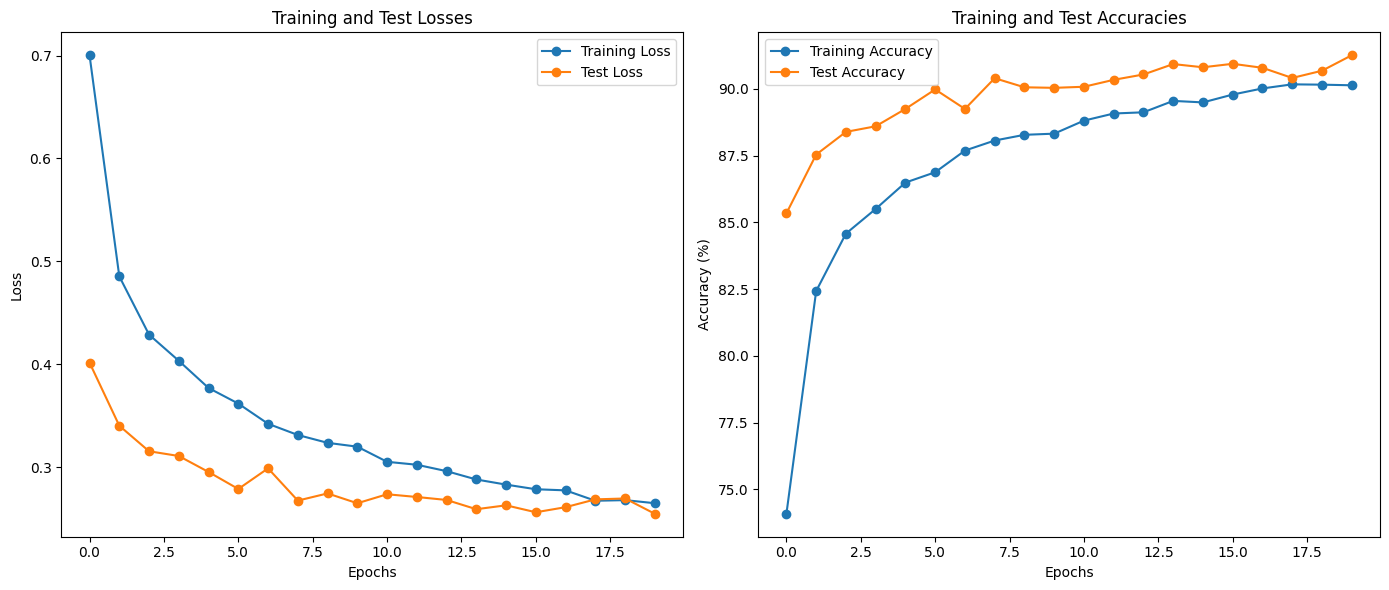

In [ ]:
plot_training_and_testing(train_losses, train_accuracies, test_losses, test_accuracies)


In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds.numpy(), all_labels.numpy()

In [ ]:
test_preds, test_labels = get_all_preds(model, test_dl)


In [ ]:
conf_matrix = confusion_matrix(test_labels, test_preds)


In [ ]:
classes = [str(i) for i in range(10)]


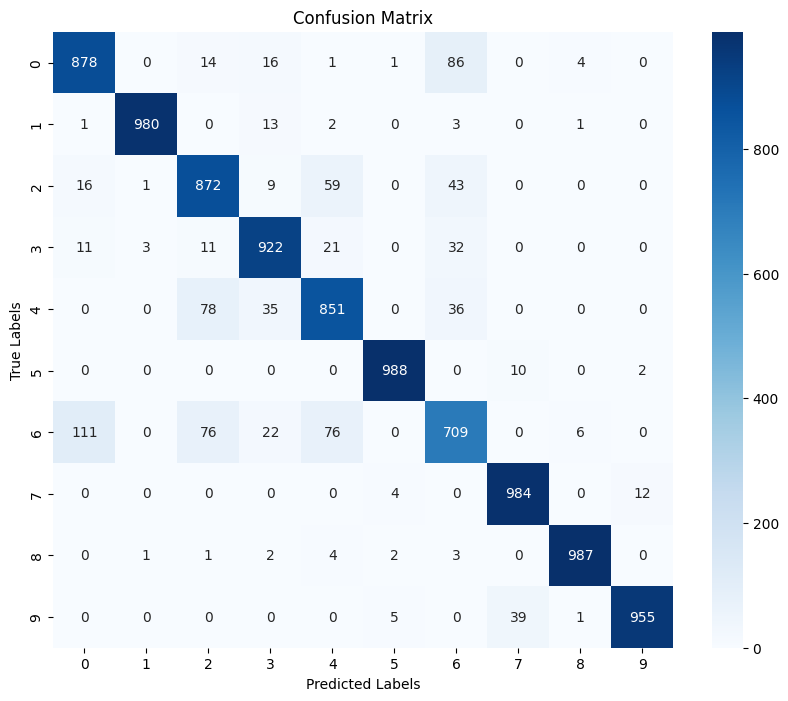

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Rede Convolucional consolidada

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torch.optim import Adam

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),  # Redimensionar a imagem para 224x224
    transforms.Grayscale(num_output_channels=3),  # Converter para 3 canais
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para o modelo VGG
])

In [ ]:
train_ds = datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

In [ ]:
val_ds = datasets.FashionMNIST(
    root=".", train=False, download=True, transform=transform
)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
vgg11 = models.vgg11(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 102MB/s]


In [ ]:
for param in vgg11.features.parameters():
    param.requires_grad = False

In [ ]:
vgg11.classifier[6] = nn.Linear(vgg11.classifier[6].in_features, 10)  # Ajustar para 10 classes do Fashion-MNIST


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg11.parameters(), lr=0.001)

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()  # Colocar o modelo em modo de avaliação
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
def train_model_vgg(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    print('a')
    model.train()  # Colocar o modelo em modo de treinamento
    print('b')
    for epoch in range(epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        print('c')
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # Zerar os gradientes do otimizador
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calcular a perda
            loss.backward()  # Backpropagation
            optimizer.step()  # Atualizar os pesos
            print('d')
            # Cálculo para estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Imprimir progresso a cada 100 lotes
            if (i + 1) % 100 == 0:
                print('e')
                print(f'Epoch {epoch+1}/{epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        print('f')
        # Calcular a acurácia e a perda média no treinamento após cada época
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

        # Validação após cada época
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

In [ ]:
train_model_vgg(vgg11, train_dl, val_dl, criterion, optimizer, epochs=1)


a
b
c
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d


KeyboardInterrupt: 

# Comparação